# Advanced street network plotting with OSMnx

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.0.0'

In [2]:
place = 'Piedmont, California, USA'
G = ox.graph_from_place(place, network_type='drive')

## Color helper functions

You can use the plot module to get colors for plotting.

In [3]:
# get n evenly-spaced colors from some matplotlib colormap
ox.plot.get_colors(n=5, cmap='plasma', return_hex=True)

['#0d0887', '#7e03a8', '#cc4778', '#f89540', '#f0f921']

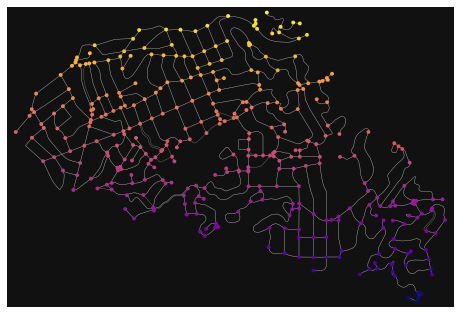

In [4]:
# get node colors by linearly mapping an attribute's values to a colormap
nc = ox.plot.get_node_colors_by_attr(G, attr='y', cmap='plasma')
fig, ax = ox.plot_graph(G, node_color=nc, edge_linewidth=0.3)

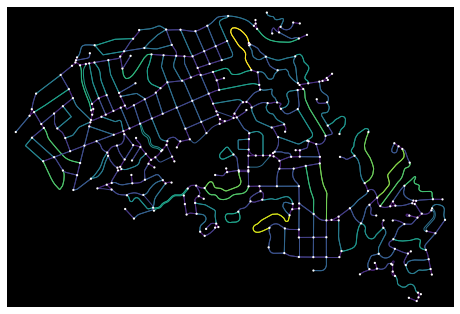

In [5]:
# when num_bins is not None, bin the nodes/edges then assign one color to each bin
# also set equal_size=True for equal-sized quantiles (requires unique bin edges!)
ec = ox.plot.get_edge_colors_by_attr(G, attr='length', num_bins=5)

# otherwise, when num_bins is None (default), linearly map one color to each node/edge by value
ec = ox.plot.get_edge_colors_by_attr(G, attr='length')

# plot the graph with colored edges
fig, ax = ox.plot_graph(G, node_size=5, edge_color=ec, bgcolor='k')

## Other plotting options

See the [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.plot.plot_graph) for full details.

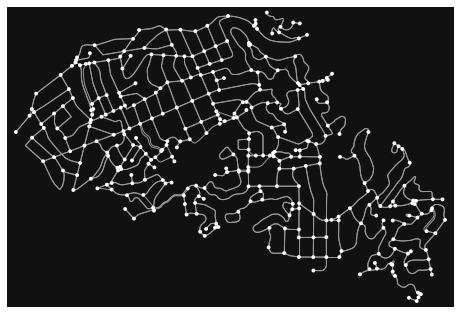

In [6]:
fig, ax = ox.plot_graph(G,
    ax=None,               #optionally draw on pre-existing axis
    figsize=(8, 8),        #figure size to create if ax is None
    bgcolor="#111111",     #background color of the plot
    node_color="w",        #color of the nodes
    node_size=15,          #size of the nodes: if 0, skip plotting them
    node_alpha=None,       #opacity of the nodes
    node_edgecolor="none", #color of the nodes' markers' borders
    node_zorder=1,         #zorder to plot nodes: edges are always 1, so set node_zorder=0 to plot nodes below edges
    edge_color="#999999",  #color of the edges
    edge_linewidth=1,      #width of the edges: if 0, skip plotting them
    edge_alpha=None,       #opacity of the edges
    show=True,             #if True, call pyplot.show() to show the figure
    close=False,           #if True, call pyplot.close() to close the figure: useful if plotting/saving many in a loop
    save=False,            #if True, save figure to disk at filepath
    filepath=None,         #if save is True, the path to the file
    dpi=300,               #if save is True, the resolution of saved file
    bbox=None)             #bounding box to constrain plot: if None, will calculate from spatial extents of graph

Use bbox to constrain the plot (i.e., "zoom") to some precise section of the graph.

For example, perhaps we consolidated nearby intersections to clean-up node clusters and want to inspect our results:

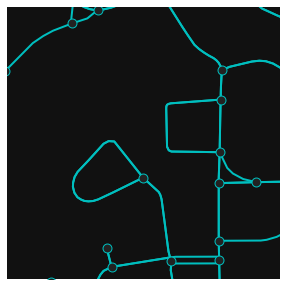

In [7]:
Gc = ox.consolidate_intersections(ox.project_graph(G), dead_ends=True)
c = ox.graph_to_gdfs(G, edges=False).unary_union.centroid
bbox = ox.utils_geo.bbox_from_point(point=(c.y, c.x), dist=200, project_utm=True)
fig, ax = ox.plot_graph(Gc, figsize=(5, 5), bbox=bbox, edge_linewidth=2, edge_color='c',
                        node_size=80, node_color='#222222', node_edgecolor='c')

In [8]:
# or save a figure to disk instead of showing it
fig, ax = ox.plot_graph(G, filepath='./images/image.png', save=True, show=False, close=True)

## Plot routes

In [9]:
# impute missing edge speeds and calculate free-flow travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# calculate 3 shortest paths, minimizing travel time
w = 'travel_time'
orig, dest = list(G)[10], list(G)[-10]
route1 = ox.shortest_path(G, orig, dest, weight=w)
orig, dest = list(G)[0], list(G)[-1]
route2 = ox.shortest_path(G, orig, dest, weight=w)
orig, dest = list(G)[-100], list(G)[100]
route3 = ox.shortest_path(G, orig, dest, weight=w)

Plot a route with the `plot_graph_route` function.

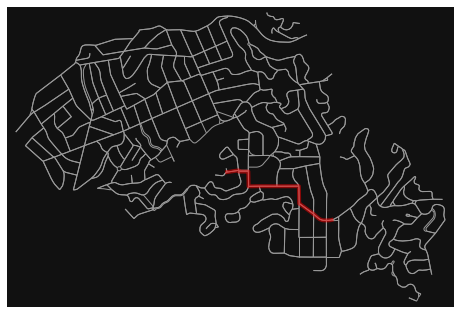

In [10]:
fig, ax = ox.plot_graph_route(G, route1, orig_dest_size=0, node_size=0)

In [11]:
# you can also pass any ox.plot_graph parameters as additional keyword args
fig, ax = ox.plot_graph_route(G, route1, save=True, show=False, close=True)

Or plot multiple routes with the `plot_graph_routes` function.

If you provide a list of route colors, each route will receive its own color.

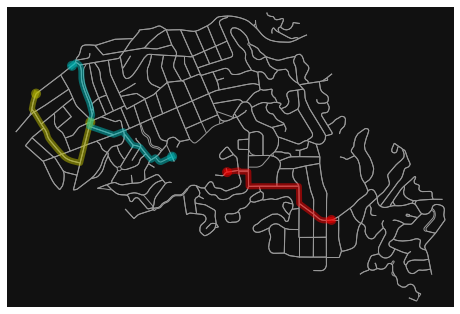

In [12]:
routes = [route1, route2, route3]
rc = ['r', 'y', 'c']
fig, ax = ox.plot_graph_routes(G, routes, route_colors=rc, route_linewidth=6, node_size=0)

## Annotate a graph's plot

Here we label each street segment with its name. Similar logic would apply to labeling nodes instead.

In [13]:
G2 = ox.graph_from_address('Piedmont, CA, USA', dist=200, network_type='drive')
G2 = ox.get_undirected(G2)

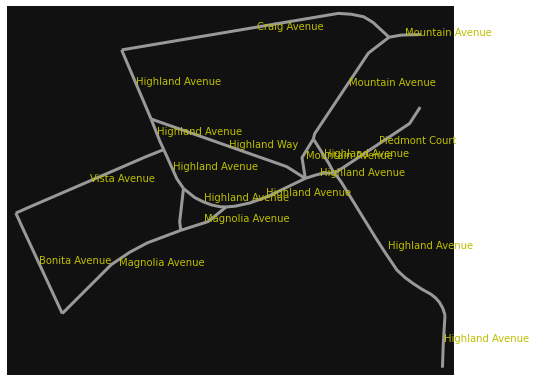

In [14]:
fig, ax = ox.plot_graph(G2, edge_linewidth=3, node_size=0, show=False, close=False)
for _, edge in ox.graph_to_gdfs(G2, nodes=False).fillna('').iterrows():
    text = edge['name']
    c = edge['geometry'].centroid
    ax.annotate(text, (c.x, c.y), c='y')
plt.show()

## Plot footprints

The `plot_footprints` function lets you plot geospatial entities (Polygons and MultiPolygons).

In [15]:
# get all the building footprints in a city
gdf = ox.geometries_from_place('Piedmont, California, USA', {'building': True})
gdf.shape

(4709, 42)

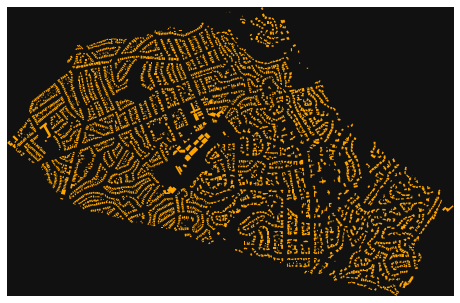

In [16]:
fig, ax = ox.plot_footprints(gdf)

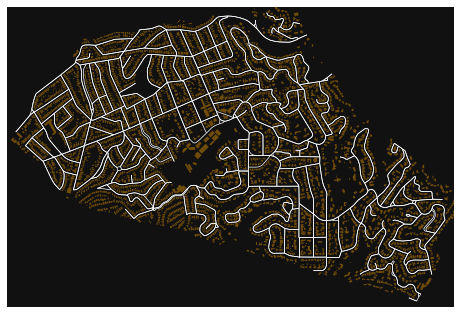

In [17]:
# or plot street network and the entities' footprints together
fig, ax = ox.plot_footprints(gdf, alpha=0.4, show=False)
fig, ax = ox.plot_graph(G, ax=ax, node_size=0, edge_color='w', edge_linewidth=0.7)